<a href="https://colab.research.google.com/github/AnirudhAnasuri/Predicting_COVID19_via_CT_Scans/blob/main/FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!ls "/content/drive/MyDrive/Covid-19_Dataset"

#total of 2481 data images, 1229 Non-COVID & 1252 COVID - relatively balanced classes

all_data  COVID  non-COVID


In [4]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

In [5]:
bs = 64 #standard batch size

In [7]:
path = '/content/drive/MyDrive/Covid-19_Dataset/all_data'
path_img = path

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/content/drive/MyDrive/Covid-19_Dataset/all_data/Non-Covid (1206).png'),
 PosixPath('/content/drive/MyDrive/Covid-19_Dataset/all_data/Non-Covid (1179).png'),
 PosixPath('/content/drive/MyDrive/Covid-19_Dataset/all_data/Non-Covid (1178).png'),
 PosixPath('/content/drive/MyDrive/Covid-19_Dataset/all_data/Non-Covid (1187).png'),
 PosixPath('/content/drive/MyDrive/Covid-19_Dataset/all_data/Non-Covid (119).png')]

In [9]:
pat = r'/([^/]+)\s\(\d+\)\.png$' #regex format to obtain class names and image files

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs, seed=42
                                   ).normalize(imagenet_stats)

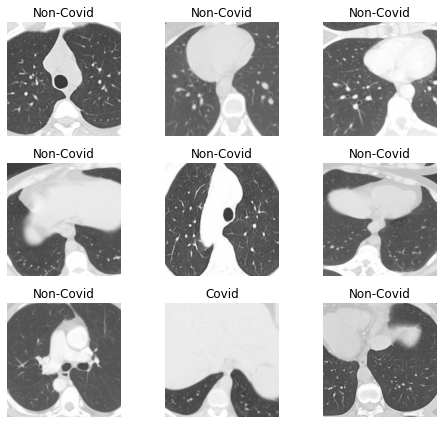

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
print(data.classes)
len(data.classes),data.c

['Covid', 'Non-Covid']


(2, 2)

In [13]:
#classes here are about the same and therefore balanced, so accuracy and error_rate are okay metrics (no need for auc)

learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.901151,0.570160,0.225806,0.774194,05:59
1,0.659621,0.334312,0.141129,0.858871,00:27
2,0.503982,0.271196,0.118952,0.881048,00:27
3,0.429632,0.275787,0.116935,0.883065,00:27


In [16]:
learn.save('stage-1')

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

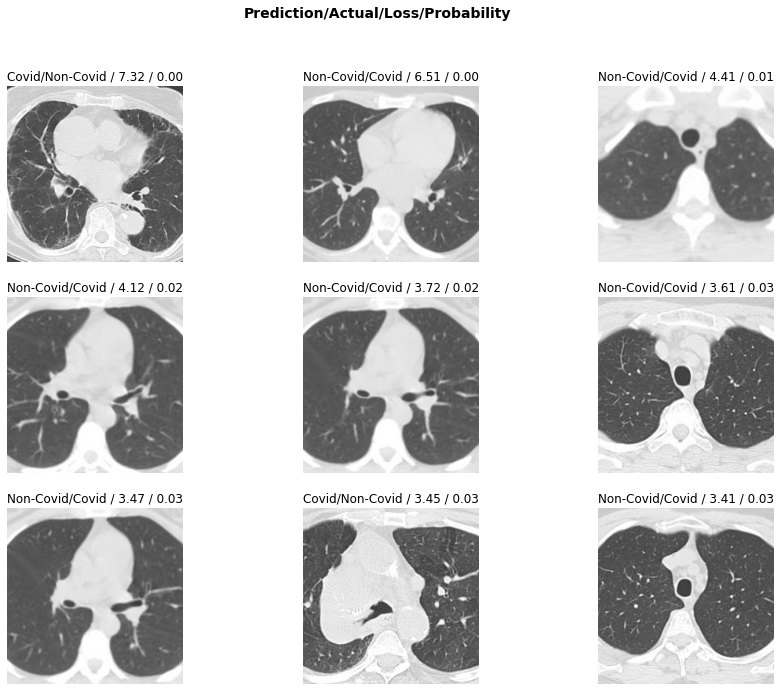

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

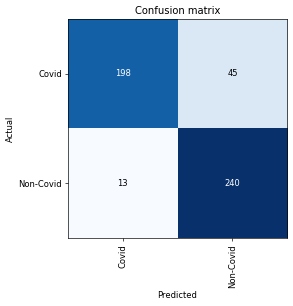

In [19]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [20]:
interp.most_confused()

[('Covid', 'Non-Covid', 45), ('Non-Covid', 'Covid', 13)]

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.392060,0.334683,0.106855,0.893145,00:28


In [23]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1985 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Non-Covid,Non-Covid,Non-Covid,Non-Covid,Non-Covid
Path: /content/drive/MyDrive/Covid-19_Dataset/all_data;

Valid: LabelList (496 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Non-Covid,Non-Covid,Covid,Non-Covid,Non-Covid
Path: /content/drive/MyDrive/Covid-19_Dataset/all_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


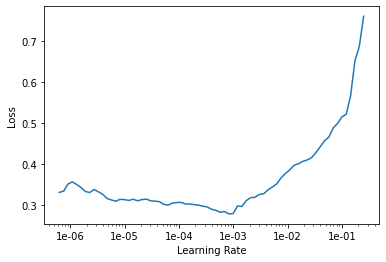

In [25]:
learn.recorder.plot()

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(2, max_lr=slice(1e-06, 1e-03)) #picking learning rate values with relatively low loss

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.332933,0.184998,0.076613,0.923387,00:28
1,0.270785,0.176484,0.062500,0.937500,00:28


In [28]:
interp = ClassificationInterpretation.from_learner(learn)

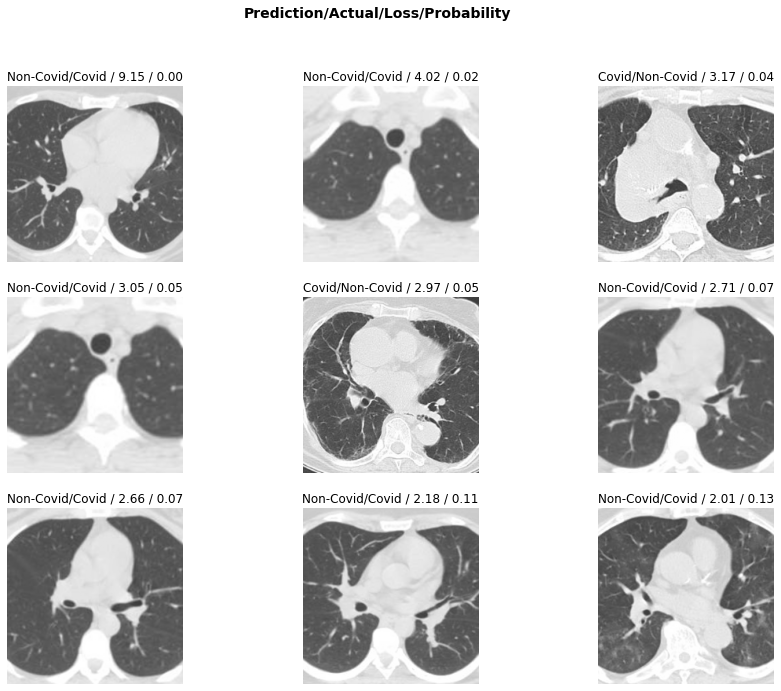

In [29]:
interp.plot_top_losses(9, figsize=(15,11))

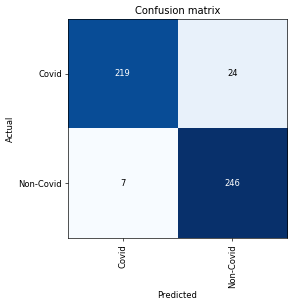

In [30]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [31]:
interp.most_confused()

[('Covid', 'Non-Covid', 24), ('Non-Covid', 'Covid', 7)]